In [1]:
import os, inspect, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

CURRENT_DIR = os.path.dirname(inspect.getabsfile(inspect.currentframe()))
ROOT_DIR = os.path.dirname(CURRENT_DIR)
sys.path.insert(0, ROOT_DIR)

from reb.src.pyts import series_to_supervised

Using TensorFlow backend.


In [2]:
ffname = os.path.join(ROOT_DIR, "reb", "data", "ext", "data_monthly_processed.csv")

In [3]:
df = pd.read_csv(ffname, parse_dates=["DATE"])
df.DATE = pd.to_datetime(df.DATE, format="%Y-%m")
df.head()


,DATE,PAYEMS,USPRIV,AWHNONAG,CES9091000001,USGOVT,UNEMPLOY,LNS13023622,LNS13023706,LNS13023654,LNS13026511,MVPHGFD027MNFRBDAL,MORTGAGE30US,DGS10
0,1987-01-01,100683,83638,34.7,3060,17045,7892,49.7,11.0,13.5,36.1,1743.4,9.2,7.1
1,1987-02-01,100915,83879,34.9,3064,17036,7865,48.5,13.1,12.6,35.9,1768.3,9.1,7.3
2,1987-03-01,101164,84100,34.7,3072,17064,7862,48.2,12.6,12.5,35.7,1756.0,9.0,7.2
3,1987-04-01,101502,84393,34.7,3073,17109,7542,49.0,12.6,12.8,36.2,1701.8,9.8,8.0
4,1987-05-01,101728,84616,34.8,3078,17112,7574,47.6,12.5,12.4,35.2,1713.6,10.6,8.6


Make a clen copy of data. This allows us to modify freely while we have always the original data for any further reference.

In [4]:
df_original = df.copy() 

Reindex data frame per the time stamps

In [5]:
df.set_index("DATE", inplace=True)
df.head()

,PAYEMS,USPRIV,AWHNONAG,CES9091000001,USGOVT,UNEMPLOY,LNS13023622,LNS13023706,LNS13023654,LNS13026511,MVPHGFD027MNFRBDAL,MORTGAGE30US,DGS10
DATE,,,,,,,,,,,,,
1987-01-01,100683,83638,34.7,3060,17045,7892,49.7,11.0,13.5,36.1,1743.4,9.2,7.1
1987-02-01,100915,83879,34.9,3064,17036,7865,48.5,13.1,12.6,35.9,1768.3,9.1,7.3
1987-03-01,101164,84100,34.7,3072,17064,7862,48.2,12.6,12.5,35.7,1756.0,9.0,7.2
1987-04-01,101502,84393,34.7,3073,17109,7542,49.0,12.6,12.8,36.2,1701.8,9.8,8.0
1987-05-01,101728,84616,34.8,3078,17112,7574,47.6,12.5,12.4,35.2,1713.6,10.6,8.6


In [6]:
# rescale data
values = df.values
values = values.astype("float32")
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values)
n_variables = values.shape[1]

In [7]:
index_target = 0
# set model parameters
n_lags = 6
n_sequences = 6
n_train = int(values.shape[0] * 0.8)
n_units = 40

In [8]:
# set train parameters
optimizer = "adam"
loss = "mse"
n_epochs = 20
sz_batch = 10
verbose = 1


In [9]:
df_reframed = series_to_supervised(values_scaled, n_lags, n_sequences)
df_reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var4(t+2),var5(t+2),var6(t+2),var7(t+2),var8(t+2),var9(t+2),var10(t+2),var11(t+2),var12(t+2),var13(t+2)
3,0.000000,0.000000,0.894735,0.472574,0.001510,0.244251,0.324675,0.470085,0.569892,0.357401,...,0.507736,0.014765,0.194205,0.277056,0.641026,0.451613,0.361011,0.003430,0.900,0.8625
4,0.004774,0.005566,1.000000,0.478200,0.000000,0.241516,0.272727,0.649573,0.473118,0.350181,...,0.513361,0.020805,0.181035,0.268398,0.717949,0.483871,0.346570,0.002324,0.875,0.8625
5,0.009898,0.010669,0.894735,0.489451,0.004698,0.241212,0.259740,0.606838,0.462366,0.342960,...,0.520394,0.022819,0.180326,0.212121,0.709402,0.419355,0.317689,0.003830,0.875,0.9125
6,0.016853,0.017436,0.894735,0.490858,0.012248,0.208793,0.294372,0.606838,0.494624,0.361011,...,0.528833,0.016611,0.164218,0.199134,0.709402,0.408602,0.314079,0.000000,0.950,0.9875
7,0.021504,0.022586,0.947367,0.497890,0.012752,0.212035,0.233766,0.598291,0.451613,0.324910,...,0.544304,0.039094,0.176882,0.277056,0.675214,0.580645,0.317689,0.005073,1.000,1.0000


In [10]:
# create train/valid data
# split into train and test sets
values = df_reframed.values
train_values, valid_values = values[:n_train, :], values[n_train:, :]


In [11]:
# split into input and targets
n_train, n_ = train_values.shape
n_valid, n_ = valid_values.shape
n_features = n_lags * n_variables


In [12]:
# split into input and targets
n_train = train_values.shape[0]
n_valid = valid_values.shape[0]
n_observations = n_lags * n_variables
x_train, y_train = train_values[:, :n_observations], train_values[:, n_observations+index_target:n_train:n_variables]
x_valid, y_valid = valid_values[:, :n_observations], valid_values[:, n_observations+index_target:n_valid:n_variables]
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (304, 39), Train Targets Shape: (304, 3)
Valid Inputs Shape: (71, 39), Valid Targets Shape: (71, 3)


In [13]:
# reshape data as required by ltsm
x_train = x_train.reshape((n_train, n_lags, n_variables))
x_valid = x_valid.reshape((n_valid, n_lags, n_variables))
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (304, 3, 13), Train Targets Shape: (304, 3)
Valid Inputs Shape: (71, 3, 13), Valid Targets Shape: (71, 3)


In [14]:
# build model
model = Sequential()
model.add(LSTM(n_units, input_shape=(n_lags, n_variables)))
model.add(Dense(n_sequences))
model.compile(loss=loss, optimizer=optimizer)

In [15]:
# train model
history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=sz_batch,
                    validation_data=(x_valid, y_valid),
                    verbose=verbose,
                    shuffle=False)

Train on 256 samples, validate on 53 samples
Epoch 1/20
256/256 [==============================] - 2s 7ms/step - loss: 0.0427 - val_loss: 0.0570
Epoch 2/20
256/256 [==============================] - 0s 2ms/step - loss: 0.1279 - val_loss: 0.1619
Epoch 3/20
256/256 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0818
Epoch 4/20
256/256 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0479
Epoch 5/20
256/256 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0316
Epoch 6/20
256/256 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0248
Epoch 7/20
256/256 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0231
Epoch 8/20
256/256 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0180
Epoch 9/20
256/256 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0138
Epoch 10/20
256/256 [==============================] - 

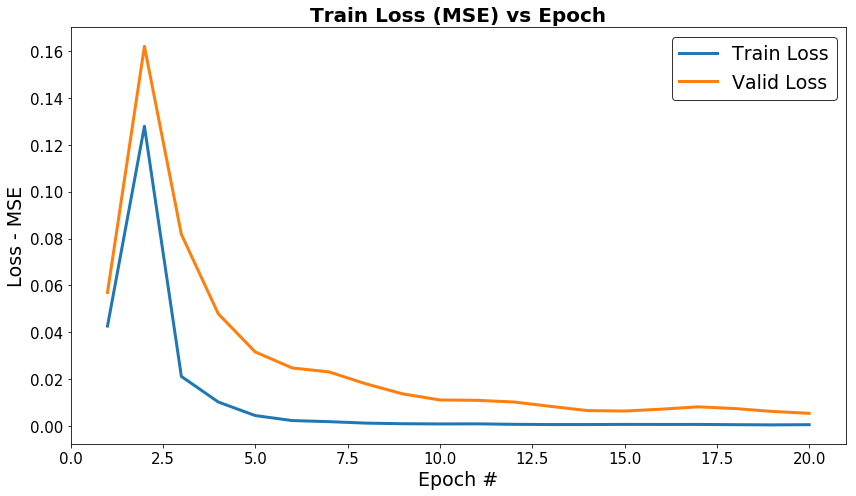

In [16]:
# plot history
figsize = (12, 7)
titlefontsize = 20
xtickfontsize = 15
ytickfontsize = 15
labelfontsize = 19
legendfontsize = 19
linewidth = 3
fig = plt.figure(figsize=figsize)
ax = fig.subplots(1, 1)
ax.plot(np.arange(1, n_epochs+1), history.history['loss'],
        "-",
        linewidth=linewidth,
        label='Train Loss')
ax.plot(np.arange(1, n_epochs+1), history.history['val_loss'],
        "-",
        linewidth=linewidth,
        label='Valid Loss')
ax.set_xlabel("Epoch #", fontsize=labelfontsize)
ax.set_ylabel("Loss - " + loss.upper(), fontsize=labelfontsize)
ax.tick_params(
    axis='x',          
    which='both',      
    labelsize=xtickfontsize)
ax.tick_params(
    axis='y',    
    labelsize=ytickfontsize)
ax.set_title("Train Loss " +  f"({loss})".upper() + " vs Epoch",
        fontsize=titlefontsize,
        fontweight="bold"
    )
ax.legend(loc="upper right",
          fontsize=legendfontsize,
          framealpha=0.8,
          fancybox=True,
          frameon=True,
          shadow=False,
          edgecolor="k")
ax.set_xlim([0, n_epochs+1])
plt.tight_layout()
fname = f"loss-plot-valid.png"
# fig.savefig(os.path.join(ROOT_DIR, "reports", "figures", fname), transparent=False, dpi=dpi)
plt.show()

In [17]:
# make a prediction
yhat_valid = model.predict(x_valid)

In [18]:
temp = x_valid.reshape((n_valid, n_lags*n_variables))
temp[-n_sequences*n_variables:][:, index_target:n_sequences*n_variables:n_variables] = \
    y_valid.reshape((n_valid, n_sequences))
temp = temp.reshape((-1, n_variables))
y_valid = scaler.inverse_transform(temp)[:, index_target]

temp = x_valid.reshape((n_valid, n_lags*n_variables))
temp[-n_sequences*n_variables:][:, index_target:n_sequences*n_variables:n_variables] = \
    yhat_valid.reshape((n_valid, n_sequences))
temp = temp.reshape((-1, n_variables))
yhat_valid = scaler.inverse_transform(temp)[:, index_target]

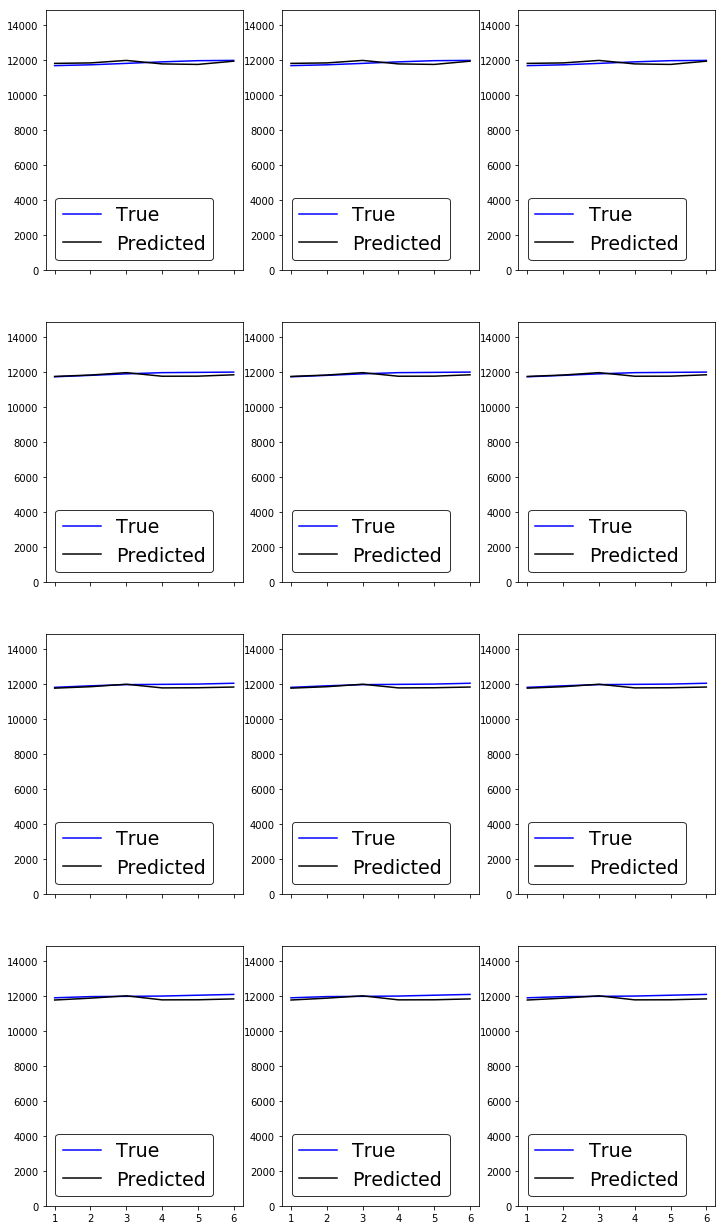

In [19]:
n = 12
ncols = 3
fig, axs = plt.subplots(nrows=int(np.ceil(n/ncols)),
                        ncols=ncols,
                        figsize=(12, 22),
                        sharex=True)
for k in range(n):
    i = k // ncols
    j = k % ncols
    axs[i, j].plot(np.arange(1,n_sequences+1),
                   y_valid[i*n_sequences:i*n_sequences+n_sequences],
                   color="blue",
                   label="True")
    axs[i, j].plot(np.arange(1,n_sequences+1),
                   yhat_valid[i*n_sequences:i*n_sequences+n_sequences],
                   color="black",
                   label="Predicted")
    
    
    axs[i, j].legend(loc="best",
                     fontsize=legendfontsize,
                     framealpha=0.8,
                     fancybox=True,
                     frameon=True,
                     shadow=False,
                     edgecolor="k")
    
    axs[i, j].set_ylim([0, 1.1*max(y_valid)])
#     print(y_valid[i*n_sequences:i*n_sequences+n_sequences].shape) 
    